In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


=== Preview: first 10 rows ===


,acq_channel,app_behavioral_score,requested_credit_limit,app_channel,credit_bureau_score,stated_income,is_customer,card_type
0,Partner3,1.808232,350,web,309,15000,True,prepaid_card
1,Partner2,4.382568,500,mobile,418,23000,True,prepaid_card
2,Partner2,-0.787575,400,web,507,24000,False,upmarket_card
3,Partner3,-2.131770,300,mobile,324,38000,False,upmarket_card
4,Partner3,-1.362938,450,mobile,736,38000,True,upmarket_card
5,Partner1,-2.558481,450,web,338,33000,True,highstreet_card
6,Organic,2.056254,550,web,745,20000,False,prepaid_card
7,Organic,0.345144,350,store,330,29000,False,upmarket_card
8,Partner4,1.026125,700,web,608,18000,False,prepaid_card
9,Organic,3.559346,650,mobile,714,18000,False,highstreet_card



=== Dataset dimensions ===
Rows: 60000, Columns: 8

=== Column data types ===
acq_channel                object
app_behavioral_score      float64
requested_credit_limit      int64
app_channel                object
credit_bureau_score         int64
stated_income               int64
is_customer                  bool
card_type                  object
dtype: object

=== Non-null counts ===
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

=== Descriptive statistics (numeric) ===


,count,mean,std,min,25%,50%,75%,max
app_behavioral_score,60000.0,-0.004771,1.992763,-7.707172,-1.350186,-0.005271,1.348051,9.793673
requested_credit_limit,60000.0,524.775000,155.993125,300.000000,400.000000,500.000000,650.000000,750.000000
credit_bureau_score,60000.0,549.495650,157.133692,300.000000,402.000000,550.000000,698.000000,799.000000
stated_income,60000.0,26965.883333,7841.773457,15000.000000,20000.000000,27000.000000,34000.000000,39000.000000



=== acq_channel ===
          count  percent
Partner4  12616    21.03
Organic   12475    20.79
Partner1  11707    19.51
Partner3  11706    19.51
Partner2  11496    19.16

=== app_channel ===
        count  percent
mobile  24432    40.72
web     22516    37.53
store   13052    21.75

=== is_customer ===
       count  percent
False  35698     59.5
True   24302     40.5

=== card_type ===
                 count  percent
prepaid_card     20103    33.51
highstreet_card  19961    33.27
upmarket_card    19936    33.23


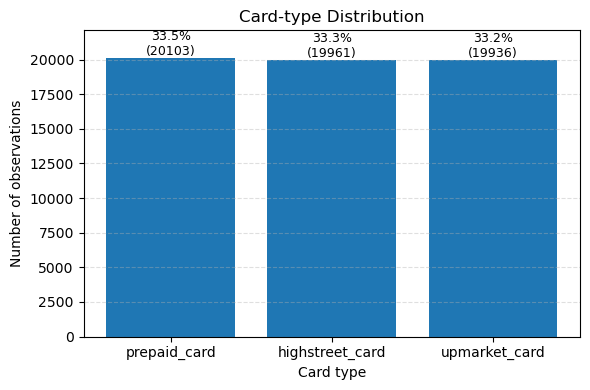


=== Missing percentage by column ===
acq_channel               0.0
app_behavioral_score      0.0
requested_credit_limit    0.0
app_channel               0.0
credit_bureau_score       0.0
stated_income             0.0
is_customer               0.0
card_type                 0.0
dtype: float64


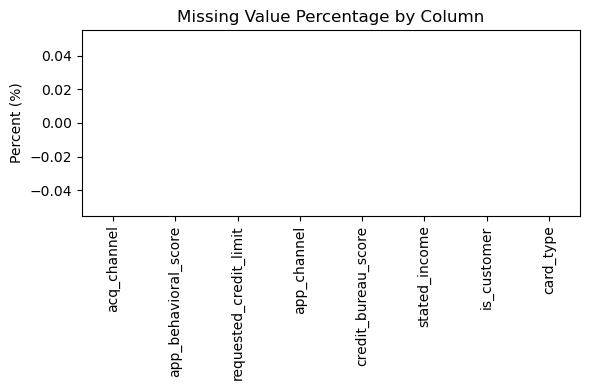

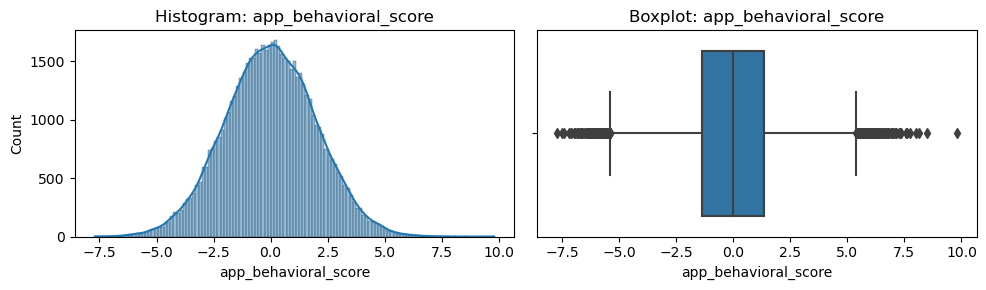

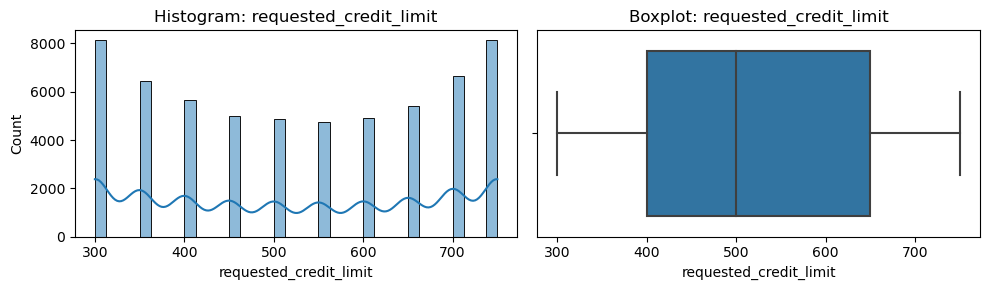

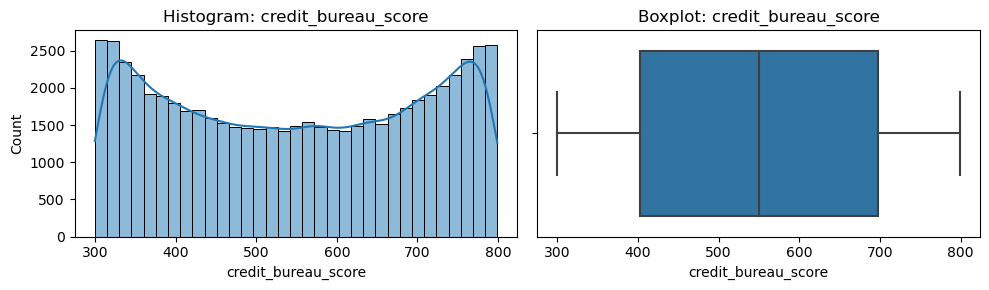

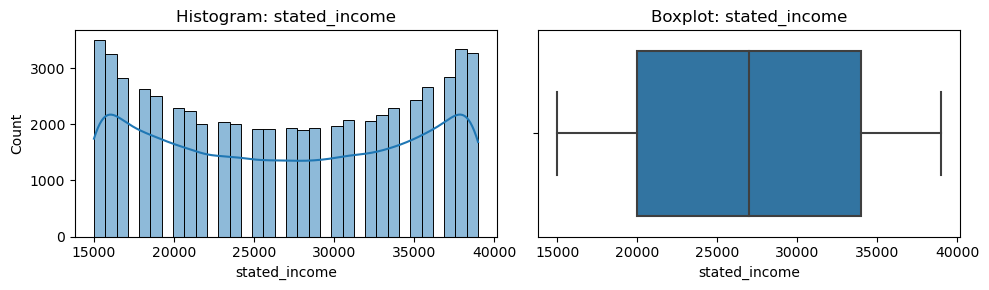


=== Outlier counts (IQR method) ===

-- k = 1.5 --
app_behavioral_score     :  386 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers

-- k = 3 --
app_behavioral_score     :    1 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers


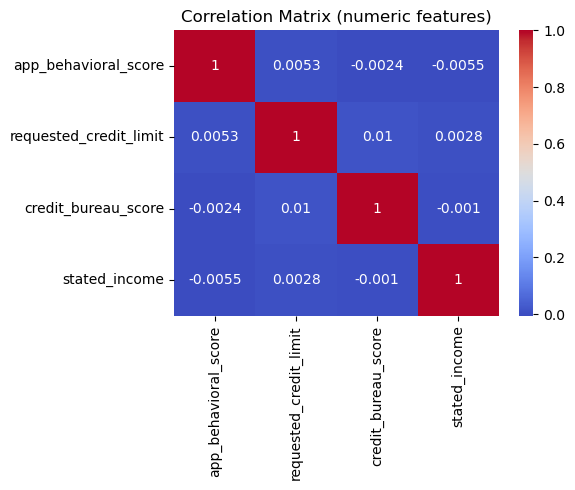

In [ ]:
# Exploratory Data Analysis (Part 1)
# ----------------------------------
# This section provides a thorough inspection of the raw dataset (`data_ori`)
# WITHOUT altering it in any way. All feature engineering is performed later
# on a deep copy of the original DataFrame.

# 1 | Load the data
# ---------------------------------------------------------------------------
DATA_PATH = 'Predict_Cardtype.csv'
data_ori  = pd.read_csv(DATA_PATH)

# 2 | Structural Overview
# ---------------------------------------------------------------------------
print("=== Preview: first 10 rows ===")
display(data_ori.head(10))

print("\n=== Dataset dimensions ===")
print(f"Rows: {data_ori.shape[0]}, Columns: {data_ori.shape[1]}")

print("\n=== Column data types ===")
print(data_ori.dtypes)

print("\n=== Non-null counts ===")
print(data_ori.isna().sum())

# 3 | Descriptive statistics
# ---------------------------------------------------------------------------
print("\n=== Descriptive statistics (numeric) ===")
display(data_ori.describe().T)

# 4 | Categorical profiling
# ---------------------------------------------------------------------------
cat_cols = ["acq_channel", "app_channel", "is_customer", "card_type"]

for col in cat_cols:
    counts   = data_ori[col].value_counts(dropna=False)
    percent  = counts / len(data_ori) * 100
    
    summary  = pd.DataFrame({
        "count":   counts,
        "percent": percent.round(2)         # round to 2 decimals
    })
    
    print(f"\n=== {col} ===")
    print(summary)

# 4a | Visualise class balance of the target variable (card_type)
# ---------------------------------------------------------------------------

# Counts and percentages
card_counts   = data_ori["card_type"].value_counts()
card_percent  = card_counts / card_counts.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(card_counts.index, card_counts.values)

# Annotations: "<pct>%\n(count)"
for bar, pct, cnt in zip(bars, card_percent, card_counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,            # slight offset above the bar
        f"{pct:.1f}%\n({cnt})",
        ha="center", va="bottom", fontsize=9
    )

# Aesthetics
ax.set_title("Card-type Distribution")
ax.set_ylabel("Number of observations")
ax.set_xlabel("Card type")
ax.set_ylim(0, card_counts.max() * 1.10)   # 10 % headroom for labels
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 5 | Missing-value audit (table + bar chart)
# ---------------------------------------------------------------------------
missing_pct = data_ori.isna().mean().sort_values(ascending=False) * 100
print("\n=== Missing percentage by column ===")
print(missing_pct)

plt.figure(figsize=(6,4))
missing_pct.plot(kind="bar")
plt.title("Missing Value Percentage by Column")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

# 6 | Distribution & outlier analysis (numeric features)
# ---------------------------------------------------------------------------
num_cols = [
    "app_behavioral_score",
    "requested_credit_limit",
    "credit_bureau_score",
    "stated_income"
]

# Histogram + boxplot loop
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.histplot(data_ori[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram: {col}")
    sns.boxplot(x=data_ori[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# IQR outlier counts (k = 1.5 and 3) and extreme value lists
print("\n=== Outlier counts (IQR method) ===")
for k in [1.5, 3]:
    print(f"\n-- k = {k} --")
    for col in num_cols:
        q1, q3 = data_ori[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask  = (data_ori[col] < lower) | (data_ori[col] > upper)
        count = mask.sum()
        print(f"{col:25s}: {count:4d} outliers")

# 7 | Correlation analysis (numerical features)
# ---------------------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(data_ori[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

In [ ]:
###############################################################################
# Feature Exploration, Engineering & Data-Frame Preparation (Part 2)
# ------------------------------------------------------------------
# All transformations are performed on a deep copy of the original data.
###############################################################################

#Please check this shit and check if standardized correctly, add feature engineering  

# 0 | Create a working copy
# ---------------------------------------------------------------------------
df = data_ori.copy(deep=True)

# 1 | Explicit type casting
# ---------------------------------------------------------------------------
df["is_customer"] = df["is_customer"].astype("boolean") #Check if this is needed
df["card_type"]   = df["card_type"].astype("object")

# 2 | Imputation
# ---------------------------------------------------------------------------
# Numeric – median; categorical – mode
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

for col in cat_cols[:-1]:   # exclude target ('card_type')
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after imputation:")
print(df.isna().sum())

# 3 | Outlier capping (IQR, k = 1.5)
# ---------------------------------------------------------------------------
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

# 4 | One-hot encode categorical predictors
# ---------------------------------------------------------------------------
predictor_cats = ["acq_channel", "app_channel", "is_customer"]
df_enc = pd.get_dummies(df, columns=predictor_cats, drop_first=True)
print("\nOne-hot encoding complete. New shape:", df_enc.shape)

# 5 | Train / test split (stratified by target)
# ---------------------------------------------------------------------------
X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("\nTrain-test split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# 6 | Scale numeric features
# ---------------------------------------------------------------------------
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
print("Numeric features scaled (zero mean, unit variance).")

# 7 | (OPTIONAL) Min-Max scaling on original data_ori for other experiments
# ---------------------------------------------------------------------------
# Note: does NOT affect df, X_train, or X_test
mms = MinMaxScaler()
data_ori_scaled = data_ori.copy()
data_ori_scaled[num_cols] = mms.fit_transform(data_ori_scaled[num_cols])

# 8 | Ready for modeling
# ---------------------------------------------------------------------------
print("\nData-preparation pipeline complete — ready for model building!")


Missing values after imputation:
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

One-hot encoding complete. New shape: (60000, 12)

Train-test split complete:
X_train: (42000, 11), X_test: (18000, 11)
Numeric features scaled (zero mean, unit variance).

Data-preparation pipeline complete — ready for model building!
